In [1]:
import io
import os
import time
from datetime import datetime
from typing import Iterable

from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile
from PIL import Image

In [2]:
load_dotenv()
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")

In [3]:
client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

In [4]:
assistant = client.beta.assistants.create(
    name="Math Tutor",
    instructions="You are a personal math tutor. Write and run code to answer math questions.",
    tools=[{"type": "code_interpreter"}],
    model=api_deployment_name,
)

thread = client.beta.threads.create()

In [5]:
def format_messages(messages: Iterable[MessageFile]) -> None:
    message_list = []

    # Get all the messages till the last user message
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width // 2, height // 2), Image.LANCZOS)
                # Display image
                image.show()

In [6]:
def process_message(content: str) -> None:
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="Please address the user as Jane Doe. The user has a premium account. Be assertive, accurate, and polite. Ask if the user has further questions. "
        + "The current date and time is: "
        + datetime.now().strftime("%x %X")
        + ". ",
    )
    print("processing ...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            # Handle completed
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        if run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            answer = messages.data[0].content[0].text.value
            print(f"Failed User:\n{content}\nAssistant:\n{answer}\n")
            # Handle failed
            break
        if run.status == "expired":
            # Handle expired
            print(run)
            break
        if run.status == "cancelled":
            # Handle cancelled
            print(run)
            break
        if run.status == "requires_action":
            # Handle function calling and continue processing
            pass
        else:
            time.sleep(5)

In [7]:
process_message("What is the linear equation when two (x,y) points are (1,1) and (5,10)?")

processing ...
user:
What is the linear equation when two (x,y) points are (1,1) and (5,10)?

assistant:
To find the linear equation in the form y = mx + b (where m is the slope and b is the y-intercept), we need to follow these steps:

1. Calculate the slope (m) using the formula:
\[ m = \frac{y_2 - y_1}{x_2 - x_1} \]

For our points, (1,1) and (5,10), we can denote them as:
\[ (x_1, y_1) = (1, 1) \]
\[ (x_2, y_2) = (5, 10) \]

2. Calculate the y-intercept (b) using the point-slope form of an equation, plugging one of the points into the equation along with the slope:
\[ y - y_1 = m(x - x_1) \]

Let's calculate the slope first.

assistant:
The slope (m) of the line is 2.25. Now, using this slope and one of the points, let's calculate the y-intercept (b) with the equation \( y - y_1 = m(x - x_1) \).
By plugging in the point (1, 1):

\[ 1 - 1 = 2.25(1 - x_1) \]

Let's solve this equation for \( b \).

assistant:
The y-intercept (b) of the line is -1.25. Thus, the linear equation that pa

In [8]:
process_message("I need to solve the equation `3x + 11 = 14`. Can you help me?")

processing ...
user:
I need to solve the equation `3x + 11 = 14`. Can you help me?

assistant:
Certainly! To solve the equation \(3x + 11 = 14\), we need to isolate the variable x on one side of the equation. Here are the steps:

1. Subtract 11 from both sides of the equation to get the term with x by itself on one side:
\[ 3x + 11 - 11 = 14 - 11 \]

2. Divide both sides of the equation by 3 to solve for x:
\[ \frac{3x}{3} = \frac{3}{3} \]

Let's do the calculations to find the value of x.

assistant:
The solution to the equation \(3x + 11 = 14\) is \(x = 1\).

If you have any more questions or need further assistance, please let me know, Jane Doe!



processing ...
user:
x=r*cos(u)sin(v)
y=r*sin(u)sin(v)
r=2+sin(7*u+5*v) 

for 0<u<2π and 0<v<π.

Create a graph of the equation z=r*cos(v).

assistant:
To create a graph of the equation \( z = r \cdot \cos(v) \) using the given parametric equations for x and y, and the expression for r, we will plot a 3D graph where u and v vary within the specified ranges. The range for u is from 0 to \( 2\pi \) and the range for v is from 0 to \( \pi \).

Let's generate the 3D plot for this surface.



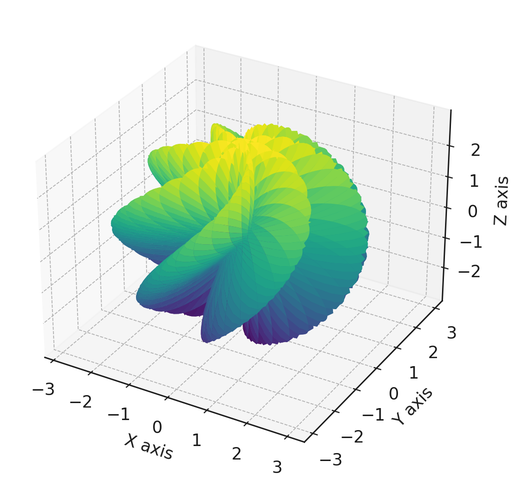

assistant:
The 3D graph above represents the surface described by the given parametric equations and the equation \( z = r \cdot \cos(v) \), within the specified ranges for u and v.

Would you like any further assistance or clarification, Jane Doe?



In [9]:
process_message(
    """x=r*cos(u)sin(v)
y=r*sin(u)sin(v)
r=2+sin(7*u+5*v) 

for 0<u<2π and 0<v<π.

Create a graph of the equation z=r*cos(v)."""
)

In [10]:
client.beta.assistants.delete(assistant.id)
client.beta.threads.delete(thread.id)

ThreadDeleted(id='thread_hdQcaB4XOqJHUelbq1TnoaNV', deleted=True, object='thread.deleted')